## 预测房价
本节我们将通过Kaggle⽐赛，将所学知识付诸实践。Kaggle的房价预测⽐赛是⼀个很好的起点。此数据集由Bart de
Cock于2011年收集 (De Cock, 2011)，涵盖了2006-2010年期间亚利桑那州埃姆斯市的房价。这个数据集是相
当通⽤的，不会需要使⽤复杂模型架构。它⽐哈⾥森和鲁宾菲尔德的波⼠顿房价71 数据集要⼤得多，也有更
多的特征。

## 下载和缓存数据集
⾸先，我们建⽴字典DATA_HUB，它可以将数据集名称的字符串映射到数据集相关的⼆元组上，这个⼆元组包含数据
集的url和验证⽂件完整性的sha-1密钥。所有类似的数据集都托管在地址为DATA_URL的站点上。  


In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下载数据集，将数据集缓存在本地⽬录（默认情况下为../data）中，并返回下载⽂
件的名称。如果缓存⽬录中已经存在此数据集⽂件，并且其sha-1与存储在DATA_HUB中的相匹配，我们将使⽤
缓存的⽂件，以避免重复的下载。  
Python的assert是用来检查一个条件，如果它为真，就不做任何事。如果它为假，则会抛出AssertError并且包含错误信息。

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')): #@save
    """下载⼀个DATA_HUB中的⽂件，返回本地⽂件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname


需实现两个实⽤函数：⼀个将下载并解压缩⼀个zip或tar⽂件，另⼀个是将本书中使⽤的所有数据集
从DATA_HUB下载到缓存⽬录中。

In [3]:
def download_extract(name, folder=None): #@save
    """下载并解压zip/tar⽂件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar⽂件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all(): #@save
    """下载DATA_HUB中的所有⽂件"""
    for name in DATA_HUB:
        download(name)


## 访问和读取数据集
竞赛数据分为训练集和测试集。每条记录都包括房屋的属性值和属性，如街道类型、施⼯年份、屋顶
类型、地下室状况等。这些特征由各种数据类型组成。例如，建筑年份由整数表⽰，屋顶类型由离散类别表
⽰，其他特征由浮点数表⽰。

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

#使⽤上⾯定义的脚本下载并缓存Kaggle房屋数据集
DATA_HUB['kaggle_house_train'] = ( #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = ( #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

#使⽤pandas分别加载包含训练数据和测试数据的两个CSV⽂件
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))


训练数据集包括1460个样本，每个样本80个特征和1个标签，⽽测试数据集包含1459个样本，每个样本80个特征。


In [5]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


查看前四个和最后两个特征，以及相应标签（房价）。


In [6]:
#0:4表示行，[0,1,2,3,-3,-2,-1]表示前4列和后两列
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


可以看到，在每个样本中，第⼀个特征是ID，这有助于模型识别每个训练样本。虽然这很⽅便，但它不携带任何⽤于预测的信息。因此，在将数据提供给模型之前，我们将其从数据集中删除。


In [7]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## 数据预处理
⾸先，我们将所有缺失的值替换为相应特征的平均值。然后，为了将所有特征放在⼀个共同的尺度上，我们通过将特征重新缩放到零均值和单位⽅差来标准化数据：  
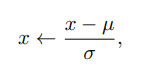  
其中µ和σ分别表⽰均值和标准差。现在，这些特征具有零均值和单位⽅差，即 E[x−µ/σ] = µ−µ/σ = 0和E[(x −µ)^2] = (σ^2 + µ^2) − 2µ^2 + µ^2 = σ^2。直观地说，我们标准化数据有两个原因：⾸先，它⽅便优化。其次，因为
我们不知道哪些特征是相关的，所以我们不想让惩罚分配给⼀个特征的系数⽐分配给其他任何特征的系数更⼤。

In [8]:
# 若⽆法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# 将所有缺失的值替换为相应特征的平均值，将特征重新缩放到零均值和单位⽅差来标准化数据
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

处理离散值。例如“MSZoning”的原始值为“RL”，则：“MSZoning_RL”为1，“MSZoning_RM”为0。（⽤独热编码替换它们）

In [9]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指⽰符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape


(2919, 331)

可以看到此转换会将特征的总数量从79个增加到331个。最后，通过values属性，我们可以从pandas格式中提
取NumPy格式，并将其转换为张量表⽰⽤于训练。

In [10]:
#将数据转换为张量表示
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## 训练
⾸先，我们训练⼀个带有损失平⽅的线性模型。显然线性模型很难让我们在竞赛中获胜，但线性模型提供了
⼀种健全性检查，以查看数据中是否存在有意义的信息。如果我们在这⾥不能做得⽐随机猜测更好，那么我
们很可能存在数据处理错误。如果⼀切顺利，线性模型将作为基线（baseline）模型，让我们直观地知道最
好的模型有超出简单的模型多少。


In [11]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net


房价就像股票价格⼀样，我们关⼼的是相对数量，⽽不是绝对数量。因此，我们更关⼼相对误差y−yˆ/y ，⽽不是绝对误差y − yˆ。  
解决这个问题的⼀种⽅法是⽤价格预测的对数来衡量差异。事实上，这也是⽐赛中官⽅⽤来评价提交质量的误差指标。
这使得预测价格的对数与真实标签价格的对数之间出现以下均⽅根误差：  
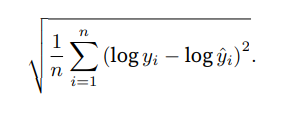


In [12]:
def log_rmse(net, features, labels):
    # 为了在取对数时进⼀步稳定该值，将⼩于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()


与前⾯的部分不同，我们的训练函数将借助Adam优化器。Adam优化器的主要吸引⼒在于它对初始学习率不那么敏感。


In [13]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这⾥使⽤的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证
K折交叉验证，它有助于模型选择和超参数调整。我们⾸先需
要定义⼀个函数，在K折交叉验证过程中返回第i折的数据。具体地说，它选择第i个切⽚作为验证数据，其余
部分作为训练数据。注意，这并不是处理数据的最有效⽅法，如果我们的数据集⼤得多，会有其他解决办法。

In [14]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid


In [15]:
#当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值。
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 模型选择
选择了⼀组未调优的超参数，并将其留给读者来改进模型。找到⼀组调优的超参数可能需要时间，这取决于⼀个⼈优化了多少变量。有了⾜够⼤的数据集和合理设置的超参数，K折交叉验证往往对多次测试具有相当的稳定性。然⽽，如果我们尝试了不合理的超参数，我们可能会发现验证效果不再代表真正的误差。

折1，训练log rmse0.170204, 验证log rmse0.156687
折2，训练log rmse0.162247, 验证log rmse0.189522
折3，训练log rmse0.164079, 验证log rmse0.168392
折4，训练log rmse0.167783, 验证log rmse0.154817
折5，训练log rmse0.162922, 验证log rmse0.183179
5-折验证: 平均训练log rmse: 0.165447, 平均验证log rmse: 0.170519


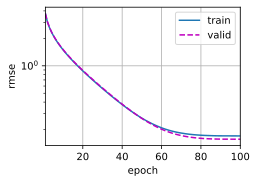

In [16]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

注意，有时⼀组超参数的训练误差可能⾮常低，但K折交叉验证的误差要⾼得多，这表明模型过拟合了。在
整个训练过程中，我们希望监控训练误差和验证误差这两个数字。较少的过拟合可能表明现有数据可以⽀撑
⼀个更强⼤的模型，较⼤的过拟合可能意味着我们可以通过正则化技术来获益。

## 提交Kaggle预测
知道应该选择什么样的超参数，我们不妨使⽤所有数据对其进⾏训练（⽽不是仅使⽤交叉验证中使
⽤的1 − 1/K的数据）。然后，我们通过这种⽅式获得的模型可以应⽤于测试集。将预测保存在CSV⽂件中可
以简化将结果上传到Kaggle的过程。


In [17]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将⽹络应⽤于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)


如果测试集上的预测与K倍交叉验证过程中的预测相似，那就是时候把它们上传到Kaggle了。下⾯的代码将
⽣成⼀个名为submission.csv的⽂件。

训练log rmse：0.162639


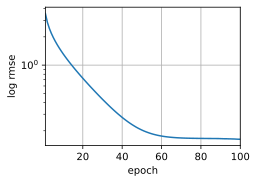

In [18]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

提交预测到Kaggle上，并查看在测试集上的预测与实际房价（标签）的⽐较情况。
* 登录Kaggle⽹站，访问房价预测竞赛⻚⾯。
* 点击“Submit Predictions”或“Late Submission”按钮
* 点击⻚⾯底部虚线框中的“Upload Submission File”按钮，选择要上传的预测⽂件。
* 点击⻚⾯底部的“Make Submission”按钮，即可查看结果。  
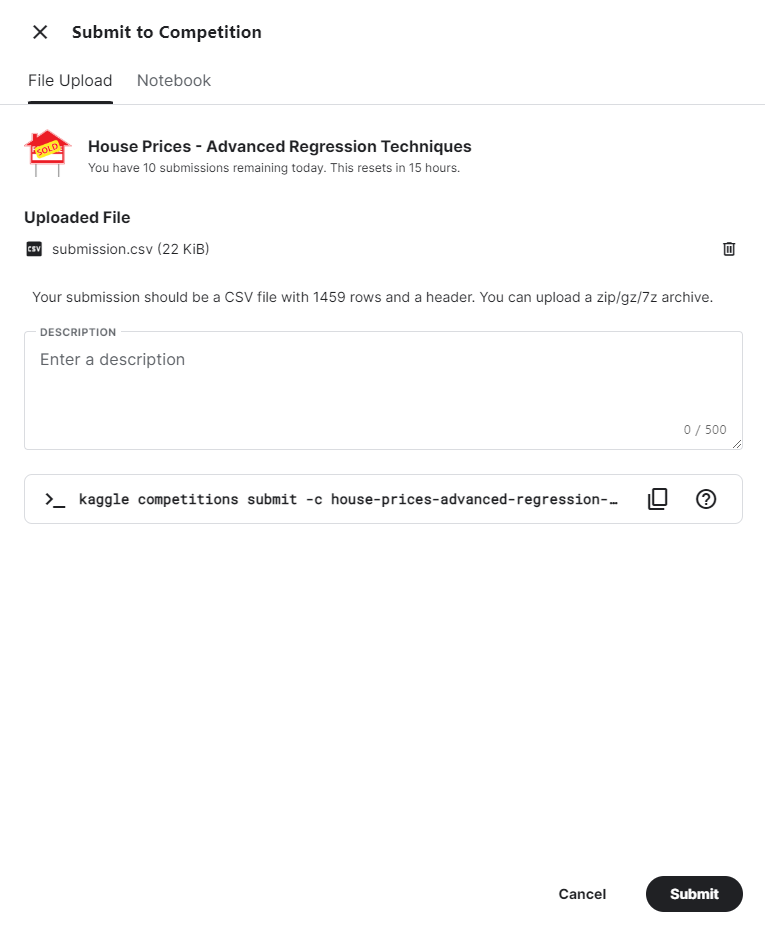

## 小结
* 真实数据通常混合了不同的数据类型，需要进⾏预处理。
* 常⽤的预处理⽅法：将实值数据重新缩放为零均值和单位⽅法；⽤均值替换缺失值。
* 将类别特征转化为指标特征，可以使我们把这个特征当作⼀个独热向量来对待。
* 我们可以使⽤K折交叉验证来选择模型并调整超参数。
* 对数对于相对误差很有⽤。